# <font color="#114b98">Catégorisez automatiquement des questions</font>

## <font color="#114b98">Notebook de test de différents modèles</font>

**Stack Overflow** est un site célèbre de questions-réponses liées au développement informatique.

L'objectif de ce projet est de développer un système de **suggestion de tags** pour ce site. Celui-ci prendra la forme d’un algorithme de machine learning qui assignera automatiquement plusieurs tags pertinents à une question.

**Livrable** : Un notebook de test de différents modèles.

## <font color="#114b98">Sommaire</font>
[1. Chargement du jeu de données](#section_1)

[2. Approche non supervisée afin de proposer des mots clés](#section_2)

[3. Approche supervisée avec TF-IDF](#section_3)

[4. Approche supervisée avec bag-of-words](#section_4)

[5. Approche supervisée avec Word Embedding : Word2Vec](#section_5)

[6. Approche supervisée avec Word Embedding : BERT](#section_6)

[7. Approche supervisée avec Sentence Embedding : USE](#section_7)

## <font color="#114b98" id="section_1">1. Chargement du jeu de données</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import ast
import random
# import warnings
# warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
plt.rc('axes', titlesize=22) 
plt.rc('axes', labelsize=18) 
titleprops = {'fontsize':20}
textprops = {'fontsize':15}
plt.style.use('ggplot')

In [4]:
main_path = 'N:/5 - WORK/1 - Projets/Projet 5/'
files = os.listdir(main_path+'saved_ressources/')
files

['bows.mm',
 'bows.mm.index',
 'bows1.mm',
 'bows1.mm.index',
 'bows2.mm',
 'bows2.mm.index',
 'data_cleaned.csv']

In [5]:
data = pd.read_csv(main_path+'saved_ressources/'+'data_cleaned.csv', encoding='utf8')

In [6]:
data = data.applymap(lambda x: ast.literal_eval(x))

In [7]:
data.head()

,Tags,Texts
0,"[macos, emacs, scheme, interpreter, sicp]","[interpreter, emacs, interpreter, python, inte..."
1,"[c#, functional-programming, delegates, lambda...","[scope, bug, compiler, voidfunction, delegate,..."
2,"[mysql, database, arrays, postgresql, stored-p...","[pass, array, procedure, pass, array, procedur..."
3,"[ios, objective-c, iphone, cocoa-touch, uibutton]","[state, need, figure, button, state, documenta..."
4,"[database, nhibernate, exception-handling, con...","[check, application, column, name, constraint,..."


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159599 entries, 0 to 159598
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Tags    159599 non-null  object
 1   Texts   159599 non-null  object
dtypes: object(2)
memory usage: 2.4+ MB


Le jeu de données est trop important pour les temps de calculs à ma disposition.

J'ai deux possibilités : 
- prendre un sample de 5000 observations aléatoirement
- prendre les 5000 observations pour lesquelles la similarité entre les deux colonnes est importante

In [9]:
# data_sample = data.sample(5000)
# data_sample.reset_index(inplace=True, drop=True)
# print(data_sample.shape)
# data_sample.head()

In [10]:
from typing import List

In [11]:
def jaccard_similarity(list1: List[str], list2: List[str]) -> float:
    set1 = set(list1)
    set2 = set(list2)
    intersection = set1.intersection(set2)
    union = set1.union(set2)
    jaccard_similarity = len(intersection) / len(union)
    return jaccard_similarity

def get_highest_similarity_rows(data: pd.DataFrame, col1: str, col2: str, n: int):
    data["jaccard_similarity"] = data.apply(lambda x: jaccard_similarity(x[col1], x[col2]), axis=1)
    data = data.sort_values(by="jaccard_similarity", ascending=False)
    return data.head(n)


data_sample = get_highest_similarity_rows(data, "Tags", "Texts", 5000)
data_sample.drop(['jaccard_similarity'], axis=1, inplace=True)
data_sample.reset_index(inplace=True, drop=True)
print(data_sample.shape)
data_sample.head()

(5000, 2)


,Tags,Texts
0,"[javascript, jquery, string, date, object]","[jquery, javascript, convert, date, string, da..."
1,"[canvas, point, bezier, curve, coordinate]","[coordinate, point, curve, canvas, point, canvas]"
2,"[listview, javafx, tableview, scrollbar, hide]","[hide, scrollbar, listview, javafx, hide, scro..."
3,"[apache, import, export, repository, jackrabbit]","[way, import, export, apache, jackrabbit, way,..."
4,"[javascript, location, window, href, window-ob...","[window, location, href, window, javascript, d..."


In [12]:
texts_list = data_sample["Texts"].to_list()
tags_list = data_sample["Tags"].to_list()

In [13]:
flat_texts = [" ".join(text) for text in texts_list]
flat_tags = [" ".join(tag) for tag in tags_list]

In [14]:
vocabulary_texts = list(set([word for item in texts_list for word in item]))
vocabulary_tags = list(set([word for item in tags_list for word in item]))

## <font color="#114b98" id="section_2">2. Approche non supervisée afin de proposer des mots clés</font>

In [15]:
from sklearn.decomposition import LatentDirichletAllocation, NMF
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel

LDA (Latent Dirichlet Allocation) est une technique de topic modeling qui permet de découvrir les thèmes cachés (ou "latents") dans un ensemble de textes. Elle permet de regrouper des textes qui traitent des mêmes sujets.

La classe LdaModel de gensim est basée sur l'algorithme d'allocation latente de Dirichlet (LDA), qui est un modèle probabiliste génératif utilisé pour découvrir les sujets cachés dans un corpus de textes. La classe LatentDirichletAllocation de scikit-learn est également basée sur l'algorithme LDA, mais elle peut avoir des différences en termes d'implémentation, comme l'algorithme d'optimisation utilisé ou les paramètres disponibles.

NMF (Non-negative Matrix Factorization) est une autre technique de topic modeling qui permet de décomposer une matrice document-terme en deux matrices de facteurs non-négatifs. Elle est souvent utilisée pour découvrir les thèmes cachés dans des textes.

La classe gensim Nmf est basée sur l'algorithme de factorisation de matrice non-négative, qui est différente de la classe NMF de scikit-learn, qui est basée sur la méthode de gradient projeté.

In [16]:
def determine_optimal_num_topics(data, vectorizer, n_topics_range, texts_list):
    """
    Given data, a vectorizer, a range of number of topics to test, and the list of texts,
    applies the models to the data and plots the silhouette and coherence scores to help 
    determine the optimal number of topics.
    
    """

    # Vectorize the data
    data = vectorizer.fit_transform(data)
    dictionary = Dictionary(texts_list)
    corpus = [dictionary.doc2bow(txt) for txt in texts_list]

    # Initialize lists to store scores for LDA and NMF
    lda_scores = []
    nmf_scores = []
    coherence_nmf = []
    coherence_lda = []

    # Loop through the range of number of topics
    for n_topics in n_topics_range:
        
        # Calculate the silhouette score for the LDA model
        lda = LatentDirichletAllocation(n_components=n_topics, max_iter=300)
        lda.fit(data)
        topic_assignments = lda.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        lda_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the silhouette score for the NMF model
        nmf = NMF(n_components=n_topics, max_iter=300)
        nmf.fit(data)
        topic_assignments = nmf.transform(data)
        labels = np.argmax(topic_assignments, axis=1)
        nmf_scores.append(silhouette_score(topic_assignments, labels, metric='euclidean'))
        
        # Calculate the coherence score for the LDA model
        lda = LdaModel(corpus, num_topics=n_topics, id2word=dictionary)
        cm_lda = CoherenceModel(model=lda, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_lda.append(cm_lda.get_coherence())
            
        # Calculate the coherence score for the NMF model
        nmf = Nmf(corpus, num_topics=n_topics, id2word=dictionary)
        cm_nmf = CoherenceModel(model=nmf, texts=texts_list, dictionary=dictionary, coherence='c_v')
        coherence_nmf.append(cm_nmf.get_coherence())
     
    scores = pd.DataFrame(columns=['topics_silhouette',
                                   'score_silhouette',
                                   'topics_coherence',
                                   'score_coherence'], 
                          index=['LDA', 'NMF'])

    scores['topics_silhouette'] = [n_topics_range[np.argmax(lda_scores)], n_topics_range[np.argmax(nmf_scores)]]
    scores['score_silhouette'] = [max(lda_scores), max(nmf_scores)]
    scores['topics_coherence'] = [n_topics_range[np.argmax(coherence_lda)], n_topics_range[np.argmax(coherence_nmf)]]
    scores['score_coherence'] = [max(coherence_lda), max(coherence_nmf)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    ax1.plot(n_topics_range, lda_scores, label='LDA')
    ax1.plot(n_topics_range, nmf_scores, label='NMF')
    ax1.set_xlabel('Number of Topics')
    ax1.set_ylabel('Silhouette score')
    ax1.legend()

    ax2.plot(n_topics_range, coherence_lda, label='LDA')
    ax2.plot(n_topics_range, coherence_nmf, label='NMF')
    ax2.set_xlabel('Number of Topics')
    ax2.set_ylabel('Coherence score')
    ax2.legend()

    plt.show()
    
    return scores

In [17]:
# Define the range of number of topics to test
n_topics_range = range(2, 60, 4)

CountVectorizer() est une implémentation de l'approche bag-of-words pour la vectorisation de textes. Il convertit un ensemble de documents en un tableau de compte de mots (ou un sac de mots), où chaque ligne représente un document et chaque colonne représente un mot. Le nombre dans chaque cellule est le nombre de fois où le mot correspondant est présent dans le document correspondant.

In [18]:
# Initialize the vectorizer
vectorizer = CountVectorizer()

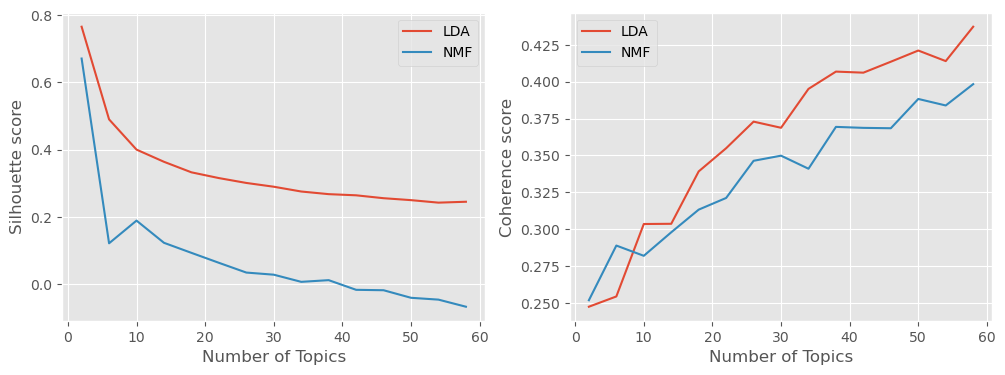

In [19]:
nmf_and_lda_models_with_CountVectorizer = determine_optimal_num_topics(flat_texts, vectorizer, n_topics_range, texts_list)

In [20]:
nmf_and_lda_models_with_CountVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.765835,58,0.437321
NMF,2,0.671195,58,0.398356


In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

TF-IDF (term frequency-inverse document frequency) est une technique utilisée pour pondérer les termes dans les textes en fonction de leur fréquence d'apparition. Elle permet de donner plus de poids aux termes qui apparaissent fréquemment dans un document mais rarement dans l'ensemble des documents.

In [22]:
# Initialize the vectorizer
tfidf_vectorizer = TfidfVectorizer(vocabulary=vocabulary_texts)

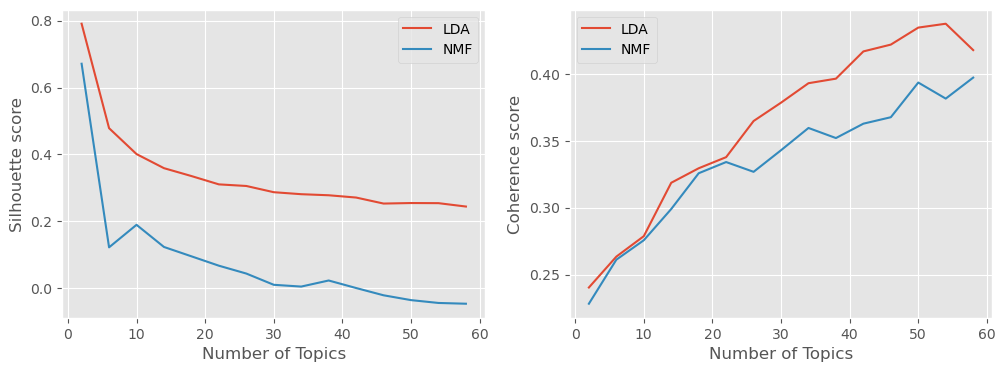

In [23]:
nmf_and_lda_models_with_TfidfVectorizer= determine_optimal_num_topics(flat_texts, vectorizer, n_topics_range, texts_list)

In [24]:
nmf_and_lda_models_with_TfidfVectorizer

,topics_silhouette,score_silhouette,topics_coherence,score_coherence
LDA,2,0.790930,54,0.437595
NMF,2,0.671193,58,0.397281


Le score de silhouette mesure la similarité d'un objet à son propre groupe par rapport aux autres groupes et généralement, plus il est proche de 1, meilleure est la classification. Le score de cohérence mesure à quel point les sujets sont "interprétables par les humains", généralement plus proche de 1, meilleur c'est.

Dans notre situation, lorsque le nombre de sujets augmente, ils sont plus "interprétables par les humains".

## <font color="#114b98" id="section_3">3. Approche supervisée avec TF-IDF</font>

In [26]:
X = tfidf_vectorizer.fit_transform(flat_texts)

In [27]:
tfidf_data = pd.DataFrame(X.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

In [28]:
print("Affichage des 15 premiers textes vectorisés par TF-IDF")
tfidf_data.head(15)

Affichage des 15 premiers textes vectorisés par TF-IDF


,gcj,mojolicious,country,fixed,gdal,es6-promise,listview,presentmodalviewcontroller,worker,bluetooth,...,urlparse,nsattributedstring,keyword,galaxy,rdoc,slice,coldfusion,xcode7.3,cordova,session-variables
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.549859,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [30]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

NameError: name 'MultinomialNB' is not defined

In [ ]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

## <font color="#114b98" id="section_4">4. Approche supervisée avec bag-of-words</font>

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [ ]:
# Convert text data to numerical feature vectors using bag of words
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(flat_texts)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

In [ ]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

## <font color="#114b98" id="section_5">5. Approche supervisée avec Word Embedding : Word2Vec</font>

In [ ]:
from gensim.models import Word2Vec
from sklearn.svm import SVC

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize

In [ ]:
texts_t = [word_tokenize(sent) for text in flat_texts for sent in sent_tokenize(text)]

In [ ]:
# Train a Word2Vec model on the text data
model = Word2Vec(texts_t, vector_size=100, window=5, min_count=1, workers=4)

In [ ]:
# Create feature vectors for the text data by averaging the word vectors
X = []
for text in texts_t:
    feature_vec = np.zeros(100)
    n_words = 0
    for word in text:
        if word in model.wv:
            feature_vec = np.add(feature_vec, model.wv[word])
            n_words += 1
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    X.append(feature_vec)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
# Train a naive bayes classifier on the training data, and make predictions on the test data
start_time = time.time()

clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

end_time = time.time()
print("Time taken: ", end_time - start_time)

In [ ]:
# Evaluate the model's accuracy
print(accuracy_score(y_test, y_pred))

## <font color="#114b98" id="section_6">6. Approche supervisée avec Word Embedding : BERT</font>

In [ ]:
# !pip install transformers

In [ ]:
# !pip install --user TensorFlow

In [ ]:
# !pip install torch

In [ ]:
# conda install pytorch torchvision torchaudio cpuonly -c pytorch

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertTokenizer
import torch
import torchvision

In [ ]:
# Load the BERT model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [ ]:
# Encode the text data as input for the BERT model
input_ids = []
attention_masks = []
for text in flat_texts:
    encoded_text = tokenizer.encode_plus(text, add_special_tokens=True, max_length=512, pad_to_max_length=True)
    input_ids.append(encoded_text["input_ids"])
    attention_masks.append(encoded_text["attention_mask"])

In [ ]:
# Convert the lists to PyTorch tensors
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
labels = torch.tensor(flat_tags)

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(input_ids, labels, test_size=0.2)

In [ ]:
# Create a DataLoader for the training set
train_dataloader = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train),
    batch_size=32,
    shuffle=True
)

In [ ]:
# Create an optimizer and scheduler for fine-tuning the BERT model
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_dataloader) * 5)

In [ ]:
# Fine-tune the BERT model on the training data
for epoch in range(5):
    model.train()
    for step, batch in enumerate(train_dataloader):
        input_ids, labels = batch
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_masks)
        loss = criterion(outputs[0], labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

In [ ]:
# Make predictions on the test data
model.eval()
with torch.no_grad():
    test_logits = model(X_test, attention_mask=attention_masks)

In [ ]:
# Convert the logits to predictions
test_preds = torch.argmax(test_logits, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, test_preds))

## <font color="#114b98" id="section_7">7. Approche supervisée avec Sentence Embedding : USE</font>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install tensorflow_hub

In [ ]:
import tensorflow_hub as hub
import tensorflow as tf

In [ ]:
# Load the USE model
use_model = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
# Encode the text data as input for the USE model
X = use_model(flat_texts).numpy()

In [ ]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, flat_tags, test_size=0.2)

In [ ]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
# Train a classifier on the encoded text data
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(len(np.unique(flat_tags)), activation='softmax')
])

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
# Evaluate the model's accuracy on the test data
print(accuracy_score(y_test, y_pred))